# Iterative datafusion

This notebook shows the evolution of posterior kinetic estimates upon iterative addition of more data as it becomes available.
It does this by rerunning the analysis for increasingly large experimental datasets, where experiments are added in a chronological fashion.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate
import sympy as sp

import ast

import pymc3 as pm
import arviz as az
import theano.tensor as tt
from numba import njit

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

from bayern import ops

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-11 14:01:45

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.2.0

bayern    : 0.1.0
numpy     : 1.20.3
sympy     : 1.8
matplotlib: 3.4.3
scipy     : 1.6.3
theano    : 1.1.2
arviz     : 0.11.4
seaborn   : 0.11.2
networkx  : 2.6.3
pandas    : 1.2.4
pymc3     : 3.11.4



In [2]:
XSIZE = 7 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def savefig(name):
    """Helper function to save figures in desired formats"""
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

def generate_figure(n_col, n_row):
    """ Helper function to generate gridspec figures"""
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs

In [3]:
import pathlib
DATA_DIR = pathlib.Path('../data/')
def load_kinetics_study(code):
    studies_files = DATA_DIR/ 'kinetic_studies.csv'
    studies_df = pd.read_csv(studies_files, index_col=0)
    study = studies_df.loc[code]
    data_df = pd.read_csv(DATA_DIR/study.data_path)
    data_df = data_df.assign(**{
        'code': code,
        'kf': study.flowrate/(study.volume*60),
        f'{study.enzyme}': study.enzyme_concentration,
        f'{study.enzyme}_batch': study.bead_batch
    })
    return data_df

def load_network_study(code):
    network_studies = pd.read_csv(f"{DATA_DIR}/network_studies.csv",
        converters={'enzyme_concentration': ast.literal_eval,
                    'bead_batch': ast.literal_eval,
                    'observables': ast.literal_eval
            }, index_col=0
    )
    study = network_studies.loc[code]
    return study



def load_HK_studies(studies):
    df_HK = pd.concat([load_kinetics_study(study) for study in studies], ignore_index=True)
    try:
        df_HK.ADP_obs = df_HK.ADP_obs.fillna(df_HK.G6P_obs)
    except AttributeError:
        df_HK = df_HK.assign(
            ADP_obs = df_HK.G6P_obs
        )
    df_HK.G6P_obs = df_HK.G6P_obs.fillna(df_HK.ADP_obs)
    df_HK = df_HK.assign(
        ATP_obs = df_HK.ATP_in - df_HK.G6P_obs,
        G_obs = df_HK.G_in - df_HK.G6P_obs
    )
    return df_HK

def load_GDH_studies(studies):
    df_GDH = pd.concat([load_kinetics_study(study) for study in studies], ignore_index=True)
    df_GDH = df_GDH.assign(
        NAD_obs = df_GDH.NAD_in - df_GDH.NADH_obs,
        G_obs = df_GDH.G_in - df_GDH.NADH_obs
    )
    return df_GDH

def load_HK_GDH_1_studies(studies):
    df_HK_GDH_1 = []

    for study in studies:
        study_info = load_network_study(study)
        data = pd.read_csv(f"{DATA_DIR}/{study_info.data_path}")
        data = data.assign(
            code = study,
            kf = study_info.flowrate/(study_info.volume*60),
            GDH = study_info.enzyme_concentration[0],
            HK = study_info.enzyme_concentration[1],
            GDH_batch = study_info.bead_batch[0],
            HK_batch = study_info.bead_batch[1]
        )
        data = data.assign(
            G6P_obs = lambda x: x["ADP_obs"],
            NAD_obs = lambda x: x['NAD_in'] - x['NADH_obs'],
            ATP_obs = lambda x: x['ATP_in'] - x['ADP_obs'],
            G_obs = lambda x: x["G_in"] - x["ADP_obs"] - x["NADH_obs"],
        )
        df_HK_GDH_1.append(data)
    df_HK_GDH_1 = pd.concat(df_HK_GDH_1)
    return df_HK_GDH_1

def load_HK_GDH_2_studies(studies):
    df_HK_GDH_2 = []

    for study in studies:
        study_info = load_network_study(study)
        data = pd.read_csv(f"{DATA_DIR}/{study_info.data_path}")
        data = data.assign(
            code = study,
            kf = study_info.flowrate/(study_info.volume*60),
            GDH = study_info.enzyme_concentration[0],
            HK = study_info.enzyme_concentration[1],
            GDH_batch = study_info.bead_batch[0],
            HK_batch = study_info.bead_batch[1]
        )
        df_HK_GDH_2.append(data)
    df_HK_GDH_2 = pd.concat(df_HK_GDH_2)
    return df_HK_GDH_2

In [4]:
def load_2_experiments():
    GDH_studies = ["SNCA14", "SNCA15"]

    df_GDH = load_GDH_studies(GDH_studies)

    return df_GDH

def load_3_experiments():
    HK_studies = ["SNCA17"]
    GDH_studies = ["SNCA14", "SNCA15"]

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH

def load_4_experiments():
    HK_studies = ["SNCA17", "SNCA18"]
    GDH_studies = ["SNCA14", "SNCA15"]

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH

def load_5_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03"]
    GDH_studies = ["SNCA14", "SNCA15"]

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH

def load_6_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15"]

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    return df_HK, df_GDH

def load_7_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15"]
    HK_GDH_1_studies = ['SNKS06']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)

    return df_HK, df_GDH, df_HK_GDH_1

def load_8_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11"]
    HK_GDH_1_studies = ['SNKS06']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)

    return df_HK, df_GDH, df_HK_GDH_1

def load_9_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)

    return df_HK, df_GDH, df_HK_GDH_1

def load_10_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

def load_11_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2
    

def load_12_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

def load_13_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004', 'SNNS005']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

def load_14_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004', 'SNNS005', 'SNNS006']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

def load_15_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004', 'SNNS005', 'SNNS006', 'SNNS007']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2

def load_16_experiments():
    HK_studies = ["SNCA17", "SNCA18", "SNKS03", "SNKS04"]
    GDH_studies = ["SNCA14", "SNCA15", "SNKS11", "SNKS12", "SNKS18"]
    HK_GDH_1_studies = ['SNKS06']
    HK_GDH_2_studies = ['SNNS002', 'SNNS003', 'SNNS004', 'SNNS005', 'SNNS006', 'SNNS007']

    df_HK = load_HK_studies(HK_studies)
    df_GDH = load_GDH_studies(GDH_studies)

    df_HK_GDH_1 = load_HK_GDH_1_studies(HK_GDH_1_studies)
    df_HK_GDH_2 = load_HK_GDH_2_studies(HK_GDH_2_studies)

    return df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2


In [5]:
def get_HK_GDH_likelihood(theta_set):
    G, NAD, NADH, ATP = sym_x = sp.symbols("G, NAD, NADH, ATP", real=True)
    k_GDH_cat, K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP = sym_phi = sp.symbols("k_GDH_cat, K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP", real=True)
    G_in, NAD_in, ATP_in, kf, GDH, HK = sym_theta = sp.symbols("G_in, NAD_in, ATP_in, kf, GDH, HK", real=True)

    sym_GDH_rate = k_GDH_cat*GDH*G*NAD/((K_GDH_G+G)*(K_GDH_NAD+NAD))
    sym_HK_rate = k_HK_cat*HK*G*ATP/((K_HK_G + G)*(K_HK_ATP+ATP))

    sym_rate_equations = [
        -sym_GDH_rate-sym_HK_rate + kf*(G_in - G),
        -sym_GDH_rate + kf*(NAD_in - NAD),
        +sym_GDH_rate - kf*NADH,
        -sym_HK_rate + kf*(ATP_in - ATP)
    ]

    sym_jac_x = sp.Matrix(sym_rate_equations).jacobian(sym_x)
    sym_jac_phi = sp.Matrix(sym_rate_equations).jacobian(sym_phi)
    sym_jac_theta = sp.Matrix(sym_rate_equations).jacobian(sym_theta)

    t = sp.symbols('t')
    num_rate_equations_ode = njit(sp.lambdify([t, sym_x, sym_phi, sym_theta], sym_rate_equations, "numpy"))
    num_jac_x_ode = njit(sp.lambdify([t, sym_x, sym_phi, sym_theta], sym_jac_x, "numpy"))

    num_rate_equations = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_rate_equations, "numpy"))
    num_jac_x = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_x, "numpy"))
    num_jac_phi = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_phi, "numpy"))
    num_jac_theta = njit(sp.lambdify([sym_x, sym_phi, sym_theta], sym_jac_theta, "numpy"))

    def find_root(fun, jac, phi, theta):
        return optimize.root(fun=fun, x0=[theta[0],theta[1],0.0, theta[2]], jac=jac, args=(phi, theta)).x
    num_grad_phi = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_phi(x,phi,theta)))
    num_grad_theta = njit(lambda x,phi,theta: np.dot(-np.linalg.inv(num_jac_x(x,phi,theta)),num_jac_theta(x,phi,theta)))

    SteadyStateOp = ops.SteadyStateDatasetOp(num_rate_equations, num_jac_x, num_grad_phi, num_grad_theta, find_root, theta_set=theta_set)

    return SteadyStateOp

In [6]:
def get_simple_model(df_HK, df_GDH):
    exp_HK_idx, exp_HK_coords = df_HK.code.factorize(sort=True)
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)
    coords = {
        "exp_HK": exp_HK_coords,
        "exp_GDH": exp_GDH_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t4\n\t{len(exp_HK_coords)} experiments HK\n\t{len(exp_GDH_coords)} experiments GDH")
    print(f"Experiments: \t{len(exp_HK_coords)+len(exp_GDH_coords)}")
    print(f"Datapoints: \t{len(df_HK)+len(df_GDH)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_HK_idx = pm.Data("exp_HK_idx", exp_HK_idx)
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")
        k_HK_cat = pm.Uniform("k_HK_cat", 1, k_cat_hyper)

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        K_HK_G = pm.Uniform("K_HK_G", 1, 4000)
        K_HK_ATP  = pm.Uniform("K_HK_ATP", 1, 6000)

        sigma = pm.Exponential("sigma", 10.0)

        sigma_HK = pm.Exponential("sigma_HK", sigma, dims="exp_HK")

        HK_obs = pm.Normal("HK_obs",
                    mu=(-k_HK_cat*df_HK.HK.values*df_HK.G_obs.values*df_HK.ATP_obs.values/(df_HK.kf.values*(K_HK_G+df_HK.G_obs.values)*(K_HK_ATP + df_HK.ATP_obs.values))) + df_HK.G_in.values,
                    sigma=sigma_HK[exp_HK_idx],
                    observed=(df_HK.G_obs.values)
        )

        sigma_GDH = pm.Exponential("sigma_GDH", sigma, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

    return model


In [7]:
def get_GDH_model(df_GDH):
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)
    coords = {
        "exp_GDH": exp_GDH_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t\n\t{len(exp_GDH_coords)} experiments GDH")
    print(f"Experiments: \t{len(exp_GDH_coords)}")
    print(f"Datapoints: \t{len(df_GDH)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        sigma_GDH = pm.Exponential("sigma_GDH", 1.0, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

    return model


In [8]:
def get_intermediate_model(df_HK, df_GDH, df_HK_GDH_1):
    exp_HK_idx, exp_HK_coords = df_HK.code.factorize(sort=True)
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)

    exp_HK_GDH_1_idx, exp_HK_GDH_1_coords = df_HK_GDH_1.code.factorize(sort=True)

    GDH_batch_lookup = dict(zip(batch_GDH_coords, range(len(batch_GDH_coords))))
    batch_GDH_idx_HK_GDH_1 = df_HK_GDH_1.GDH_batch.replace(GDH_batch_lookup).values

    coords = {
        "exp_HK": exp_HK_coords,
        "exp_GDH": exp_GDH_coords,
        "exp_HK_GDH_1": exp_HK_GDH_1_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t4\n\t{len(exp_HK_coords)} experiments HK\n\t{len(exp_GDH_coords)} experiments GDH\n\t{len(exp_HK_GDH_1_coords)} experiments HK+GDH (complete observability)")
    print(f"Experiments: \t{len(exp_HK_coords)+len(exp_GDH_coords)+len(exp_HK_GDH_1_coords)}")
    print(f"Datapoints: \t{len(df_HK)+len(df_GDH)+len(df_HK_GDH_1)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_HK_idx = pm.Data("exp_HK_idx", exp_HK_idx)
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        exp_HK_GDH_1_idx = pm.Data("exp_HK_GDH_1_idx", exp_HK_GDH_1_idx)

        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)
        batch_GDH_idx_HK_GDH_1 = pm.Data("batch_GDH_idx_HK_GDH_1", batch_GDH_idx_HK_GDH_1)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")
        k_HK_cat = pm.Uniform("k_HK_cat", 1, k_cat_hyper)

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        K_HK_G = pm.Uniform("K_HK_G", 1, 4000)
        K_HK_ATP  = pm.Uniform("K_HK_ATP", 1, 6000)

        sigma = pm.Exponential("sigma", 10.0)

        sigma_HK = pm.Exponential("sigma_HK", sigma, dims="exp_HK")

        HK_obs = pm.Normal("HK_obs",
                    mu=(-k_HK_cat*df_HK.HK.values*df_HK.G_obs.values*df_HK.ATP_obs.values/(df_HK.kf.values*(K_HK_G+df_HK.G_obs.values)*(K_HK_ATP + df_HK.ATP_obs.values))) + df_HK.G_in.values,
                    sigma=sigma_HK[exp_HK_idx],
                    observed=(df_HK.G_obs.values)
        )

        sigma_GDH = pm.Exponential("sigma_GDH", sigma, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

        sigma_HK_GDH_1 = pm.Exponential("sigma_HK_GDH_1", sigma, dims="exp_HK_GDH_1")
        HK_GDH_1_obs = pm.Normal("HK_GDH_1_obs",
                    mu=-k_GDH_cat[batch_GDH_idx_HK_GDH_1]*df_HK_GDH_1.GDH.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.NAD_obs.values/(
                        df_HK_GDH_1.kf.values*(K_GDH_G+df_HK_GDH_1.G_obs.values)*(K_GDH_NAD+df_HK_GDH_1.NAD_obs.values)
                        )
                    -k_HK_cat*df_HK_GDH_1.HK.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.ATP_obs.values/(df_HK_GDH_1.kf.values*(K_HK_G+df_HK_GDH_1.G_obs.values)*(K_HK_ATP + df_HK_GDH_1.ATP_obs.values)),
                    sigma=sigma_HK_GDH_1[exp_HK_GDH_1_idx],
                    observed=(df_HK_GDH_1.G_obs.values - df_HK_GDH_1.G_in.values)
        )

    return model


In [9]:
def get_complex_model(df_HK, df_GDH, df_HK_GDH_1, df_HK_GDH_2):
    exp_HK_idx, exp_HK_coords = df_HK.code.factorize(sort=True)
    exp_GDH_idx, exp_GDH_coords = df_GDH.code.factorize(sort=True)

    batch_GDH_idx, batch_GDH_coords = df_GDH.GDH_batch.factorize(sort=True)
    batch_GDH_idx_HK_GDH_2, batch_GDH_coords_HK_GDH_2 = df_HK_GDH_2.GDH_batch.factorize(sort=True)

    exp_HK_GDH_1_idx, exp_HK_GDH_1_coords = df_HK_GDH_1.code.factorize(sort=True)
    exp_HK_GDH_2_idx, exp_HK_GDH_2_coords = df_HK_GDH_2.code.factorize(sort=True)

    GDH_batch_lookup = dict(zip(batch_GDH_coords, range(len(batch_GDH_coords))))
    batch_GDH_idx_HK_GDH_1 = df_HK_GDH_1.GDH_batch.replace(GDH_batch_lookup).values
    batch_GDH_idx_HK_GDH_2 = df_HK_GDH_2.GDH_batch.replace(GDH_batch_lookup).values

    coords = {
        "exp_HK": exp_HK_coords,
        "exp_GDH": exp_GDH_coords,
        "exp_HK_GDH_1": exp_HK_GDH_1_coords,
        "exp_HK_GDH_2": exp_HK_GDH_2_coords,
        "batch_GDH": batch_GDH_coords,
    }

    print(f"Topologies: \t4\n\t{len(exp_HK_coords)} experiments HK\n\t{len(exp_GDH_coords)} experiments GDH\n\t{len(exp_HK_GDH_1_coords)} experiments HK+GDH (complete observability)\n\t{len(exp_HK_GDH_2_coords)} experiments HK+GDH (partial observability)")
    print(f"Experiments: \t{len(exp_HK_coords)+len(exp_GDH_coords)+len(exp_HK_GDH_1_coords)+len(exp_HK_GDH_2_coords)}")
    print(f"Datapoints: \t{len(df_HK)+len(df_GDH)+len(df_HK_GDH_1)+len(df_HK_GDH_2)}")
    print(f"GDH batches: \t{len(batch_GDH_coords)}")

    with pm.Model(coords=coords) as model:
        exp_HK_idx = pm.Data("exp_HK_idx", exp_HK_idx)
        exp_GDH_idx = pm.Data("exp_GDH_idx", exp_GDH_idx)
        exp_HK_GDH_1_idx = pm.Data("exp_HK_GDH_1_idx", exp_HK_GDH_1_idx)
        exp_HK_GDH_2_idx = pm.Data("exp_HK_GDH_2_idx", exp_HK_GDH_2_idx)

        batch_GDH_idx = pm.Data("batch_GDH_idx", batch_GDH_idx)
        batch_GDH_idx_HK_GDH_1 = pm.Data("batch_GDH_idx_HK_GDH_1", batch_GDH_idx_HK_GDH_1)

        k_cat_hyper = pm.Normal("k_cat_hyper", mu=1500, sigma=500)
        k_GDH_cat = pm.Uniform("k_GDH_cat", 1, k_cat_hyper, dims="batch_GDH")
        k_HK_cat = pm.Uniform("k_HK_cat", 1, k_cat_hyper)

        K_GDH_G = pm.Uniform("K_GDH_G", 1, 20_000)
        K_GDH_NAD = pm.Uniform("K_GDH_NAD", 1, 20_000)

        K_HK_G = pm.Uniform("K_HK_G", 1, 4000)
        K_HK_ATP  = pm.Uniform("K_HK_ATP", 1, 6000)

        sigma = pm.Exponential("sigma", 10.0)

        sigma_HK = pm.Exponential("sigma_HK", sigma, dims="exp_HK")

        HK_obs = pm.Normal("HK_obs",
                    mu=(-k_HK_cat*df_HK.HK.values*df_HK.G_obs.values*df_HK.ATP_obs.values/(df_HK.kf.values*(K_HK_G+df_HK.G_obs.values)*(K_HK_ATP + df_HK.ATP_obs.values))) + df_HK.G_in.values,
                    sigma=sigma_HK[exp_HK_idx],
                    observed=(df_HK.G_obs.values)
        )

        sigma_GDH = pm.Exponential("sigma_GDH", sigma, dims="exp_GDH")
        GDH_obs = pm.Normal("GDH_obs",
                    mu=-k_GDH_cat[batch_GDH_idx]*df_GDH.GDH.values*df_GDH.G_obs.values*df_GDH.NAD_obs.values/(
                            df_GDH.kf.values*(K_GDH_G+df_GDH.G_obs.values)*(K_GDH_NAD+df_GDH.NAD_obs.values )
                        ) + df_GDH.G_in.values,
                    sigma=sigma_GDH[exp_GDH_idx],
                    observed=(df_GDH.G_obs.values)
        )

        sigma_HK_GDH_1 = pm.Exponential("sigma_HK_GDH_1", sigma, dims="exp_HK_GDH_1")
        HK_GDH_1_obs = pm.Normal("HK_GDH_1_obs",
                    mu=-k_GDH_cat[batch_GDH_idx_HK_GDH_1]*df_HK_GDH_1.GDH.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.NAD_obs.values/(
                        df_HK_GDH_1.kf.values*(K_GDH_G+df_HK_GDH_1.G_obs.values)*(K_GDH_NAD+df_HK_GDH_1.NAD_obs.values)
                        )
                    -k_HK_cat*df_HK_GDH_1.HK.values*df_HK_GDH_1.G_obs.values*df_HK_GDH_1.ATP_obs.values/(df_HK_GDH_1.kf.values*(K_HK_G+df_HK_GDH_1.G_obs.values)*(K_HK_ATP + df_HK_GDH_1.ATP_obs.values)),
                    sigma=sigma_HK_GDH_1[exp_HK_GDH_1_idx],
                    observed=(df_HK_GDH_1.G_obs.values - df_HK_GDH_1.G_in.values)
        )
        
        sigma_HK_GDH_2 = pm.Exponential("sigma_HK_GDH_2", sigma, dims="exp_HK_GDH_2")
        theta = df_HK_GDH_2[["G_in", "NAD_in", "ATP_in", "kf", "GDH", "HK"]].values
        likelihood = get_HK_GDH_likelihood(theta)

        HK_GDH_2_obs = pm.Normal(f"HK_GDH_2_obs",
                mu=likelihood(tt.stack([
                    k_GDH_cat[1], K_GDH_G, K_GDH_NAD, k_HK_cat, K_HK_G, K_HK_ATP
                ]))[:,2],
                sigma=sigma_HK_GDH_2[exp_HK_GDH_2_idx],
                observed=df_HK_GDH_2.NADH_obs.values
        )

    return model


In [10]:
def sample_2_experiments():
    df_GDH = load_2_experiments()
    model = get_GDH_model(df_GDH)
    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_2prog.nc")
def sample_3_experiments():
    df_GDH, df_HK = load_3_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_3prog.nc")
def sample_4_experiments():
    df_GDH, df_HK = load_4_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_4prog.nc")
def sample_5_experiments():
    df_GDH, df_HK = load_5_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_5prog.nc")
def sample_6_experiments():
    df_GDH, df_HK = load_6_experiments()
    model = get_simple_model(df_GDH, df_HK)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.95),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_6prog.nc")
def sample_7_experiments():
    df_GDH, df_HK, df_HK_GDH_1 = load_7_experiments()
    model = get_intermediate_model(df_GDH, df_HK, df_HK_GDH_1)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_7prog.nc")
def sample_8_experiments():
    df_GDH, df_HK, df_HK_GDH_1 = load_8_experiments()
    model = get_intermediate_model(df_GDH, df_HK, df_HK_GDH_1)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_8prog.nc")
def sample_9_experiments():
    df_GDH, df_HK, df_HK_GDH_1 = load_9_experiments()
    model = get_intermediate_model(df_GDH, df_HK, df_HK_GDH_1)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_9prog.nc")
def sample_10_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_10_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_10prog.nc")
def sample_11_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_11_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_11prog.nc")
def sample_12_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_12_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_12prog.nc")
def sample_13_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_13_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_13prog.nc")
def sample_14_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_14_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_14prog.nc")
def sample_15_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_15_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_15prog.nc")
def sample_16_experiments():
    df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2 = load_16_experiments()
    model = get_complex_model(df_GDH, df_HK, df_HK_GDH_1, df_HK_GDH_2)

    with model:
        inference_data = pm.sample(step=pm.NUTS(target_accept=0.98),
                return_inferencedata=True,
                cores=8,
                tune=1000,
                draws=1000,
                init="jitter+adapt_full")
        inference_data.to_netcdf("idata/idata_16prog.nc")

In [25]:
sample_2_experiments()
sample_3_experiments()
sample_4_experiments()
sample_5_experiments()
sample_6_experiments()
sample_7_experiments()
sample_8_experiments()
sample_9_experiments()
sample_10_experiments()
sample_11_experiments()
sample_12_experiments()
sample_13_experiments()
sample_14_experiments()
sample_15_experiments()
sample_16_experiments()


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	1 experiments HK+GDH (partial observability)
Experiments: 	10
Datapoints: 	73
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2037 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	2 experiments HK+GDH (partial observability)
Experiments: 	11
Datapoints: 	78
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2518 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	3 experiments HK+GDH (partial observability)
Experiments: 	12
Datapoints: 	83
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3077 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	4 experiments HK+GDH (partial observability)
Experiments: 	13
Datapoints: 	88
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3419 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	5 experiments HK+GDH (partial observability)
Experiments: 	14
Datapoints: 	93
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3917 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Topologies: 	4
	4 experiments HK
	4 experiments GDH
	1 experiments HK+GDH (complete observability)
	6 experiments HK+GDH (partial observability)
Experiments: 	15
Datapoints: 	108
GDH batches: 	2


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 4189 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Topologies: 	4
	4 experiments HK
	5 experiments GDH
	1 experiments HK+GDH (complete observability)
	6 experiments HK+GDH (partial observability)
Experiments: 	16
Datapoints: 	116
GDH batches: 	3


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3579 seconds.
The number of effective samples is smaller than 25% for some parameters.


Topologies: 	4
	4 experiments HK
	6 experiments GDH
	1 experiments HK+GDH (complete observability)
	6 experiments HK+GDH (partial observability)
Experiments: 	17
Datapoints: 	124
GDH batches: 	3


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma_HK_GDH_2, sigma_HK_GDH_1, sigma_GDH, sigma_HK, sigma, K_HK_ATP, K_HK_G, K_GDH_NAD, K_GDH_G, k_HK_cat, k_GDH_cat, k_cat_hyper]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3773 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9441510026918073, but should be close to 0.98. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
idata_2prog = az.from_netcdf("idata/idata_2prog.nc")
idata_3prog = az.from_netcdf("idata/idata_3prog.nc")
idata_4prog = az.from_netcdf("idata/idata_4prog.nc")
idata_5prog = az.from_netcdf("idata/idata_5prog.nc")
idata_6prog = az.from_netcdf("idata/idata_6prog.nc")
idata_7prog = az.from_netcdf("idata/idata_7prog.nc")
idata_8prog = az.from_netcdf("idata/idata_8prog.nc")
idata_9prog = az.from_netcdf("idata/idata_9prog.nc")
idata_10prog = az.from_netcdf("idata/idata_10prog.nc")
idata_11prog = az.from_netcdf("idata/idata_11prog.nc")
idata_12prog = az.from_netcdf("idata/idata_12prog.nc")
idata_13prog = az.from_netcdf("idata/idata_13prog.nc")
idata_14prog = az.from_netcdf("idata/idata_14prog.nc")
idata_15prog = az.from_netcdf("idata/idata_15prog.nc")
idata_16prog = az.from_netcdf("idata/idata_16prog.nc")

posterior_2prog_df = idata_2prog.to_dataframe(['posterior'], include_coords=False) # with GDH
posterior_3prog_df = idata_3prog.to_dataframe(['posterior'], include_coords=False) # with HK
posterior_4prog_df = idata_4prog.to_dataframe(['posterior'], include_coords=False) # with HK
posterior_5prog_df = idata_5prog.to_dataframe(['posterior'], include_coords=False) # with HK
posterior_6prog_df = idata_6prog.to_dataframe(['posterior'], include_coords=False) # with HK
posterior_7prog_df = idata_7prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 1
posterior_8prog_df = idata_8prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 1
posterior_9prog_df = idata_9prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 1
posterior_10prog_df = idata_10prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_11prog_df = idata_11prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_12prog_df = idata_12prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_13prog_df = idata_13prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_14prog_df = idata_14prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_15prog_df = idata_15prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2
posterior_16prog_df = idata_16prog.to_dataframe(['posterior'], include_coords=False) # with HK, HK+GDH 2


In [14]:
def plot_ridgeplots(fig, gs, n_plots, data, start_color=0):
    pal = sns.cubehelix_palette(n_plots, start=start_color, rot=-.2, dark=0.4, light=0.9)
    axes = [fig.add_subplot(gs[i,0]) for i in range(n_plots)]

    for i in range(n_plots):
        sns.kdeplot(data[i], ax=axes[i], fill=True, clip_on=True, alpha=0.6, color=pal[i])
        sns.kdeplot(data[i], ax=axes[i], fill=False, clip_on=True, color="black", lw=.2)


    x_min, x_max = min(axes[-1].get_xticks()),  max(axes[-1].get_xticks())
    y_max = max(max(ax.get_yticks()) for ax in axes)*1.1
    max_yticks = [max(ax.get_yticks()) for ax in axes]
    for i, ax in enumerate(axes):
        # ax.set_ylim(0, y_max)
        # ymax = max(ax.get_yticks())*(n_plots - i)
        ax.set_ylim(0, y_max)
        ax.set_xlim(x_min, x_max)
        ax.patch.set_alpha(0)

    for ax in axes[:-1]:
        ax.axis("off")
        sns.despine(ax=ax, left=True, bottom=True)

    axes[-1].set_yticks([])
    axes[-1].set_ylabel("")
    sns.despine(ax=axes[-1], left=True)

    return axes, pal

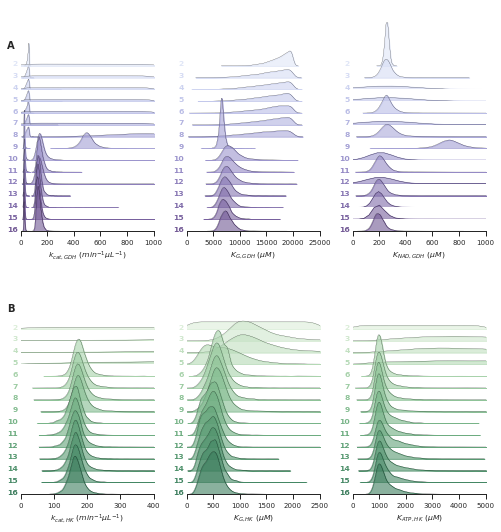

In [15]:
fig, gs = generate_figure(3,2)
fig.set_constrained_layout(False)
fig.set_tight_layout(True)
fig.set_size_inches(XSIZE, YSIZE*1.5)

HSPACE = -0.8
N_DATASETS = 15
gs_rp = gs[0,0].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_2prog_df['k_GDH_cat[0]'], 
                                            posterior_3prog_df['k_GDH_cat[0]'], 
                                            posterior_4prog_df['k_GDH_cat[0]'], 
                                            posterior_5prog_df['k_GDH_cat[0]'], 
                                            posterior_6prog_df['k_GDH_cat[0]'], 
                                            posterior_7prog_df['k_GDH_cat[0]'], 
                                            posterior_8prog_df['k_GDH_cat[0]'], 
                                            posterior_9prog_df['k_GDH_cat[0]'], 
                                            posterior_10prog_df['k_GDH_cat[0]'], 
                                            posterior_11prog_df['k_GDH_cat[0]'], 
                                            posterior_12prog_df['k_GDH_cat[0]'], 
                                            posterior_13prog_df['k_GDH_cat[0]'], 
                                            posterior_14prog_df['k_GDH_cat[0]'], 
                                            posterior_15prog_df['k_GDH_cat[0]'], 
                                            posterior_16prog_df['k_GDH_cat[0]'], 
                                            ], 
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]
axes[-1].set_xlabel("")
axes[-1].axis("off")

axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            np.linspace(0, 1000, 8000), 
                                            np.linspace(0, 1000, 8000), 
                                            np.linspace(0, 1000, 8000), 
                                            np.linspace(0, 1000, 8000), 
                                            np.linspace(0, 1000, 8000), 
                                            np.linspace(0, 1000, 8000), 
                                            posterior_8prog_df['k_GDH_cat[1]'], 
                                            posterior_9prog_df['k_GDH_cat[1]'], 
                                            posterior_10prog_df['k_GDH_cat[1]'], 
                                            posterior_11prog_df['k_GDH_cat[1]'], 
                                            posterior_12prog_df['k_GDH_cat[1]'], 
                                            posterior_13prog_df['k_GDH_cat[1]'], 
                                            posterior_14prog_df['k_GDH_cat[1]'], 
                                            posterior_15prog_df['k_GDH_cat[1]'], 
                                            posterior_16prog_df['k_GDH_cat[1]'], 
],
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]

axes[0].text(-0.1, 0.3, 'A', transform=axes[0].transAxes, weight="bold", size=10)
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$k_{cat,GDH}~(min^{-1}\mu L^{-1})$")

gs_rp = gs[0,1].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_2prog_df['K_GDH_G'], 
                                            posterior_3prog_df['K_GDH_G'], 
                                            posterior_4prog_df['K_GDH_G'], 
                                            posterior_5prog_df['K_GDH_G'], 
                                            posterior_6prog_df['K_GDH_G'], 
                                            posterior_7prog_df['K_GDH_G'], 
                                            posterior_8prog_df['K_GDH_G'], 
                                            posterior_9prog_df['K_GDH_G'], 
                                            posterior_10prog_df['K_GDH_G'], 
                                            posterior_11prog_df['K_GDH_G'], 
                                            posterior_12prog_df['K_GDH_G'], 
                                            posterior_13prog_df['K_GDH_G'], 
                                            posterior_14prog_df['K_GDH_G'], 
                                            posterior_15prog_df['K_GDH_G'], 
                                            posterior_16prog_df['K_GDH_G'], 
],
                            start_color=0.4
                            )
[ax.set_xlim(0, 25000) for ax in axes]
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$K_{G,GDH}~(\mu M)$")

gs_rp = gs[0,2].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            posterior_2prog_df['K_GDH_NAD'], 
                                            posterior_3prog_df['K_GDH_NAD'], 
                                            posterior_4prog_df['K_GDH_NAD'], 
                                            posterior_5prog_df['K_GDH_NAD'], 
                                            posterior_6prog_df['K_GDH_NAD'], 
                                            posterior_7prog_df['K_GDH_NAD'], 
                                            posterior_8prog_df['K_GDH_NAD'], 
                                            posterior_9prog_df['K_GDH_NAD'], 
                                            posterior_10prog_df['K_GDH_NAD'], 
                                            posterior_11prog_df['K_GDH_NAD'], 
                                            posterior_12prog_df['K_GDH_NAD'], 
                                            posterior_13prog_df['K_GDH_NAD'], 
                                            posterior_14prog_df['K_GDH_NAD'], 
                                            posterior_15prog_df['K_GDH_NAD'], 
                                            posterior_16prog_df['K_GDH_NAD'], 
],
                            start_color=0.4
                            )
[ax.set_xlim(0, 1000) for ax in axes]
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$K_{NAD,GDH}~(\mu M)$")

gs_rp = gs[1,0].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            np.linspace(0, 1000, 8000), 
                                            posterior_3prog_df['k_HK_cat'], 
                                            posterior_4prog_df['k_HK_cat'], 
                                            posterior_5prog_df['k_HK_cat'], 
                                            posterior_6prog_df['k_HK_cat'], 
                                            posterior_7prog_df['k_HK_cat'], 
                                            posterior_8prog_df['k_HK_cat'], 
                                            posterior_9prog_df['k_HK_cat'], 
                                            posterior_10prog_df['k_HK_cat'], 
                                            posterior_11prog_df['k_HK_cat'], 
                                            posterior_12prog_df['k_HK_cat'], 
                                            posterior_13prog_df['k_HK_cat'], 
                                            posterior_14prog_df['k_HK_cat'], 
                                            posterior_15prog_df['k_HK_cat'], 
                                            posterior_16prog_df['k_HK_cat'], 
],
                            start_color=2.4
                            )
[ax.set_xlim(0, 400) for ax in axes]
axes[0].text(-0.1, 0.3, 'B', transform=axes[0].transAxes, weight="bold", size=10)
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$k_{cat,HK}~(min^{-1}\mu L^{-1})$")

gs_rp = gs[1,1].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            np.linspace(0, 2500, 8000), 
                                            posterior_3prog_df['K_HK_G'], 
                                            posterior_4prog_df['K_HK_G'], 
                                            posterior_5prog_df['K_HK_G'], 
                                            posterior_6prog_df['K_HK_G'], 
                                            posterior_7prog_df['K_HK_G'], 
                                            posterior_8prog_df['K_HK_G'], 
                                            posterior_9prog_df['K_HK_G'], 
                                            posterior_10prog_df['K_HK_G'], 
                                            posterior_11prog_df['K_HK_G'], 
                                            posterior_12prog_df['K_HK_G'], 
                                            posterior_13prog_df['K_HK_G'], 
                                            posterior_14prog_df['K_HK_G'], 
                                            posterior_15prog_df['K_HK_G'], 
                                            posterior_16prog_df['K_HK_G'], 
                                            ], 
                            start_color=2.4
                            )
[ax.set_xlim(0, 2500) for ax in axes]
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$K_{G,HK}~(\mu M)$")

gs_rp = gs[1,2].subgridspec(N_DATASETS,1, hspace=HSPACE)
axes, pal = plot_ridgeplots(fig, gs_rp, N_DATASETS, [
                                            np.linspace(0, 5000, 8000), 
                                            posterior_3prog_df['K_HK_ATP'],
                                            posterior_4prog_df['K_HK_ATP'],
                                            posterior_5prog_df['K_HK_ATP'],
                                            posterior_6prog_df['K_HK_ATP'],
                                            posterior_7prog_df['K_HK_ATP'],
                                            posterior_8prog_df['K_HK_ATP'],
                                            posterior_9prog_df['K_HK_ATP'],
                                            posterior_10prog_df['K_HK_ATP'],
                                            posterior_11prog_df['K_HK_ATP'],
                                            posterior_12prog_df['K_HK_ATP'],
                                            posterior_13prog_df['K_HK_ATP'],
                                            posterior_14prog_df['K_HK_ATP'],
                                            posterior_15prog_df['K_HK_ATP'],
                                            posterior_16prog_df['K_HK_ATP'],
                                            ], 
                            start_color=2.4
                            )
[ax.set_xlim(0, 5000) for ax in axes]
for i, ax in enumerate(axes):
    ax.text(-0.02, 0.03, f"{i+2}", fontweight="bold", color=pal[i],
            ha="right", va="center", transform=ax.transAxes)
axes[-1].set_xlabel(r"$K_{ATP,HK}~(\mu M)$")
sns.despine(ax=axes[0], left=False)

savefig("fig_progression")